Title/Topic : NYC Vehicle Stops: Exploring When , Where and Who 
---------

In [19]:
library(lubridate)
library(dplyr)
library(ggplot2)
library(tidyverse)
library(ggmap)
library(sf)
library(RColorBrewer)

In [20]:
# Reading data; 
stop <- read.csv("NYPD_Vehicle_Stop_Reports_2024.csv", header=TRUE)

I got the dataset from from the following link: https://data.cityofnewyork.us/Public-Safety/NYPD-Vehicle-Stop-Reports/hn9i-dwpr/about_data

Due to its size and no. of rows, the removal of NA columns, selection of a subset of the data, and clearing of the rest was done outside the jupyter notebook.

In [21]:
head(stop)

EVNT_KEY,OCCUR_DT,OCCUR_TM,CMD_CD,VEH_SEIZED_FLG,VEH_SEARCHED_FLG,VEH_SEARCH_CONSENT_FLG,VEH_CHECKPOINT_FLG,FORCE_USED_FLG,ARREST_MADE_FLG,SUMMON_ISSUED_FLG,VEH_CATEGORY,RPTED_AGE,SEX_CD,RACE_DESC,LATITUDE,LONGITUDE,X_COORD_CD,Y_COORD_CD
<int>,<fct>,<fct>,<int>,<lgl>,<lgl>,<fct>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>
279873752,1/3/2024,3:35:00,49,FALSE,TRUE,Y,FALSE,FALSE,TRUE,FALSE,CAR/SUV,28,M,BLACK,40.84260,-73.85356,1024768,246293
279968971,1/4/2024,0:28:00,25,FALSE,TRUE,N,FALSE,FALSE,FALSE,FALSE,CAR/SUV,38,M,BLACK,40.80187,-73.94135,1000487,231424
279969301,1/3/2024,21:47:00,69,FALSE,TRUE,Y,FALSE,FALSE,FALSE,FALSE,CAR/SUV,34,M,BLACK,40.64430,-73.90138,1011618,174026
280282811,1/7/2024,17:00:00,71,FALSE,TRUE,Y,FALSE,FALSE,FALSE,TRUE,CAR/SUV,23,M,BLACK,40.66597,-73.92860,1004058,181915
280327012,1/10/2024,14:30:00,121,TRUE,TRUE,N,FALSE,FALSE,TRUE,FALSE,CAR/SUV,26,M,BLACK,40.63547,-74.13631,946416,170822
280326865,1/6/2024,0:45:00,105,FALSE,TRUE,N,FALSE,FALSE,FALSE,TRUE,CAR/SUV,35,M,BLACK,40.67893,-73.75071,1053395,186728


In [22]:
#Changing date format to weekday 
stop$OCCUR_DT <- strptime(as.character(stop$OCCUR_DT), "%m/%d/%Y")
stop$OCCUR_DT <- format(stop$OCCUR_DT,"%Y-%m-%d")
stop$OCCUR_DT <- strftime(stop$OCCUR_DT, "%A") 

#Find Part/Period of Day
stop <- stop %>%
    mutate (Hour = hour(hms(OCCUR_TM)),
            TPRD = case_when(Hour %in% 5:11 ~ 'Morning',
                         Hour %in% 12:17 ~ 'Afternoon',
                         Hour %in% 18:22 ~ 'Evening',
                         Hour %in% 22:24 |  Hour %in% 0:5  ~ 'Night',
                          TRUE ~ NA_character_))

#Adding Age_group column for making analysis easier. 
stop <- stop %>%
        mutate(
        Age_Group = case_when(
            RPTED_AGE <18 ~'<18',
            RPTED_AGE >=18 & RPTED_AGE <=24 ~ "18-24",
            RPTED_AGE >24 & RPTED_AGE <=44 ~ "25-44",
            RPTED_AGE >44 & RPTED_AGE <=64 ~ "45-64",
            RPTED_AGE >=65~ "65+"
        ))
#Adding Borough column
stop <- stop%>%
    mutate(
         boro = case_when( 
            LATITUDE >= 40.7000 & LATITUDE <= 40.8800 & LONGITUDE >= -74.0200 & LONGITUDE <= -73.9100 ~ "Manhattan",
            LATITUDE >= 40.7900 & LATITUDE <= 40.9200 & LONGITUDE >= -73.9300 & LONGITUDE <= -73.7700 ~ "Bronx",
            LATITUDE >= 40.5400 & LATITUDE <= 40.8000 & LONGITUDE >= -73.9600 & LONGITUDE <= -73.7000 ~ "Queens",
            LATITUDE >= 40.5700 & LATITUDE <= 40.7400 & LONGITUDE >= -74.0400 & LONGITUDE <= -73.8500 ~ "Brooklyn",
            LATITUDE >= 40.5000 & LATITUDE <= 40.6500 & LONGITUDE >= -74.2500 & LONGITUDE <= -74.0500 ~ "Staten Island",
            TRUE ~ "Unknown" 
         )   
    )

# select only required columns and rename
df <- subset(stop, select = c(EVNT_KEY,OCCUR_DT,Hour,TPRD,VEH_SEIZED_FLG,VEH_SEARCHED_FLG,FORCE_USED_FLG,ARREST_MADE_FLG,VEH_CATEGORY,Age_Group,SEX_CD,RACE_DESC,boro,LATITUDE,LONGITUDE))
colnames(df) <- c("Event_id", "Day", "Hour" ,"T_Prd", "Veh_Seized", "Veh_Search", "Force_used", "Arrested", "Veh_type","Age_Group", "Sex", "Race","Boro", "Lat","Long")

In [23]:
#df 
head(df,10)

Event_id,Day,Hour,T_Prd,Veh_Seized,Veh_Search,Force_used,Arrested,Veh_type,Age_Group,Sex,Race,Boro,Lat,Long
<int>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>
279873752,Wednesday,3,Night,FALSE,TRUE,FALSE,TRUE,CAR/SUV,25-44,M,BLACK,Bronx,40.84260,-73.85356
279968971,Thursday,0,Night,FALSE,TRUE,FALSE,FALSE,CAR/SUV,25-44,M,BLACK,Manhattan,40.80187,-73.94135
279969301,Wednesday,21,Evening,FALSE,TRUE,FALSE,FALSE,CAR/SUV,25-44,M,BLACK,Queens,40.64430,-73.90138
280282811,Sunday,17,Afternoon,FALSE,TRUE,FALSE,FALSE,CAR/SUV,18-24,M,BLACK,Queens,40.66597,-73.92860
280327012,Wednesday,14,Afternoon,TRUE,TRUE,FALSE,TRUE,CAR/SUV,25-44,M,BLACK,Staten Island,40.63547,-74.13631
280326865,Saturday,0,Night,FALSE,TRUE,FALSE,FALSE,CAR/SUV,25-44,M,BLACK,Queens,40.67893,-73.75071
280326792,Thursday,4,Night,FALSE,TRUE,FALSE,TRUE,CAR/SUV,25-44,M,BLACK,Queens,40.67772,-73.93586
280415416,Friday,8,Morning,FALSE,TRUE,FALSE,FALSE,CAR/SUV,25-44,M,BLACK,Manhattan,40.79546,-73.96563
280395120,Thursday,21,Evening,TRUE,TRUE,FALSE,TRUE,CAR/SUV,25-44,M,BLACK,Queens,40.66157,-73.90478


In [24]:
#Colors 
co = brewer.pal(9,'YlOrRd')
co1 = c('#ffeda0','#feb24c','#fd8d3c','#fc4e2a','#bd0026') #Selected colors from YlOrRd
col_m = c("#1f78b4","#e31a1c","#984ea3",'#ff7f00','#33a02c')

Vizualizations:
--------

Using a shape file for plotting NYC border using .shp file from link: "https://www.kaggle.com/datasets/dataembassy/nyc-borough-boundaries"

In [25]:
#The spatial density of vehical stops in NYC to Identify where the hot spots are and which borough has frequent stops.

my_sf <- read_sf("Shape_file/nybb.shp", layer = "nybb") %>%
        st_transform(crs = 4326) 
#Using 4326 to convert the data in the shape file to latitude and longitude coordinates, which I can use to plot the borders of NYC (and have a density layer on top of it).  

#To find the center of each borro to place a label
borough_names <- my_sf %>%
  st_centroid() %>%
  mutate(boro_name = my_sf$BoroName)

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”Warning message in st_centroid.sfc(st_geometry(x), of_largest_polygon = of_largest_polygon):
“st_centroid does not give correct centroids for longitude/latitude data”

In [26]:
borough_names

BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,boro_name
<int>,<chr>,<dbl>,<dbl>,<POINT [°]>,<chr>
5,Staten Island,330437.1,1623914223,POINT (-74.15337 40.58085),Staten Island
2,Bronx,464365.6,1186678192,POINT (-73.86654 40.85263),Bronx
4,Queens,895721.0,3044779902,POINT (-73.81849 40.70761),Queens
3,Brooklyn,741077.9,1937477754,POINT (-73.94768 40.64473),Brooklyn
1,Manhattan,361050.6,636479884,POINT (-73.96716 40.77727),Manhattan


Warning message:
“Removed 8 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 8 rows containing non-finite values (stat_density2d).”

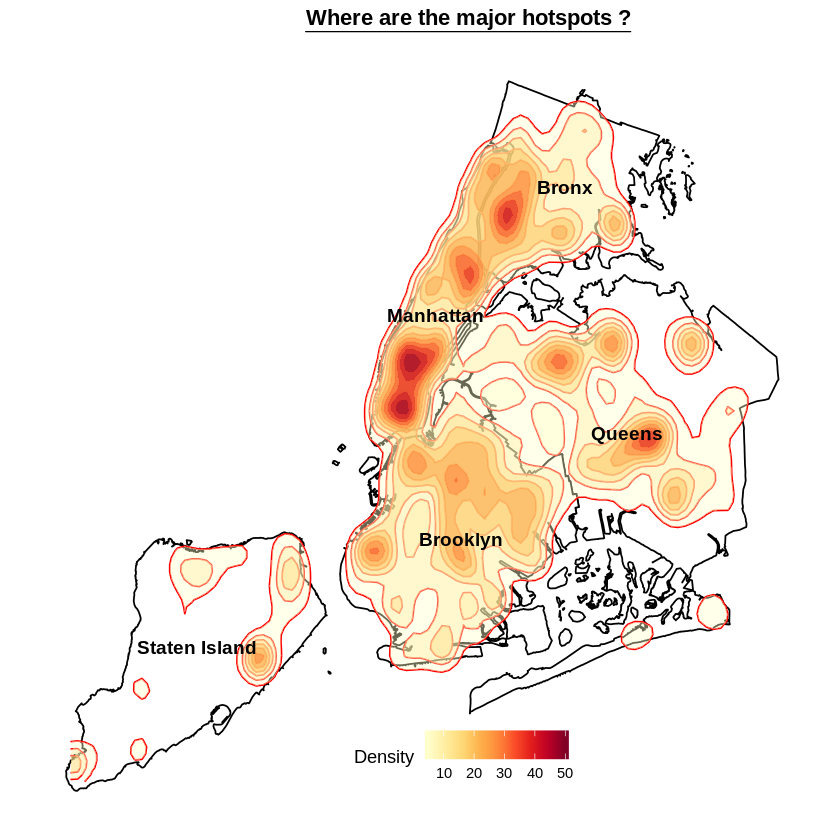

In [27]:
ggplot() +
geom_sf(data = my_sf,fill = "white", color = "black")+
geom_density_2d(data = df, aes(x = Long, y = Lat), color = "Red")+
stat_density_2d(data = df, aes(x = Long, y = Lat,fill = ..level..), geom = "polygon", alpha = 0.4)+
geom_text(data = borough_names, aes(x = st_coordinates(geometry)[,1], y = st_coordinates(geometry)[,2], label = boro_name),color = "black", size = 4, fontface = "bold" )+
scale_fill_gradientn(colors = co ) +
labs(title = expression(bold(underline("Where are the major hotspots ?"))), fill = "Density") +
theme_minimal() +
theme(plot.title = element_text(hjust=0.6),axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(),panel.grid = element_blank(),legend.position = c(0.55, 0.09), legend.direction='horizontal')   

#ggsave("Hotspot.png") 

In [28]:
#Selecting Manhattan as it has the major hotspot
df_m <- df[df$Boro == "Manhattan" ,]
head(df_m)
nrow(df_m)

,Event_id,Day,Hour,T_Prd,Veh_Seized,Veh_Search,Force_used,Arrested,Veh_type,Age_Group,Sex,Race,Boro,Lat,Long
,<int>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>
2,279968971,Thursday,0,Night,FALSE,TRUE,FALSE,FALSE,CAR/SUV,25-44,M,BLACK,Manhattan,40.80187,-73.94135
8,280415416,Friday,8,Morning,FALSE,TRUE,FALSE,FALSE,CAR/SUV,25-44,M,BLACK,Manhattan,40.79546,-73.96563
15,280673398,Tuesday,23,Night,FALSE,TRUE,FALSE,TRUE,CAR/SUV,18-24,M,BLACK,Manhattan,40.86172,-73.92505
16,280692799,Wednesday,18,Evening,TRUE,TRUE,FALSE,FALSE,MCL,18-24,M,HISPANIC,Manhattan,40.83157,-73.94298
29,281277524,Monday,0,Night,FALSE,TRUE,FALSE,FALSE,CAR/SUV,25-44,M,BLACK,Manhattan,40.86537,-73.92438
32,281450243,Wednesday,23,Night,FALSE,TRUE,FALSE,FALSE,CAR/SUV,25-44,M,BLACK,Manhattan,40.71213,-73.93929


[1] 52525

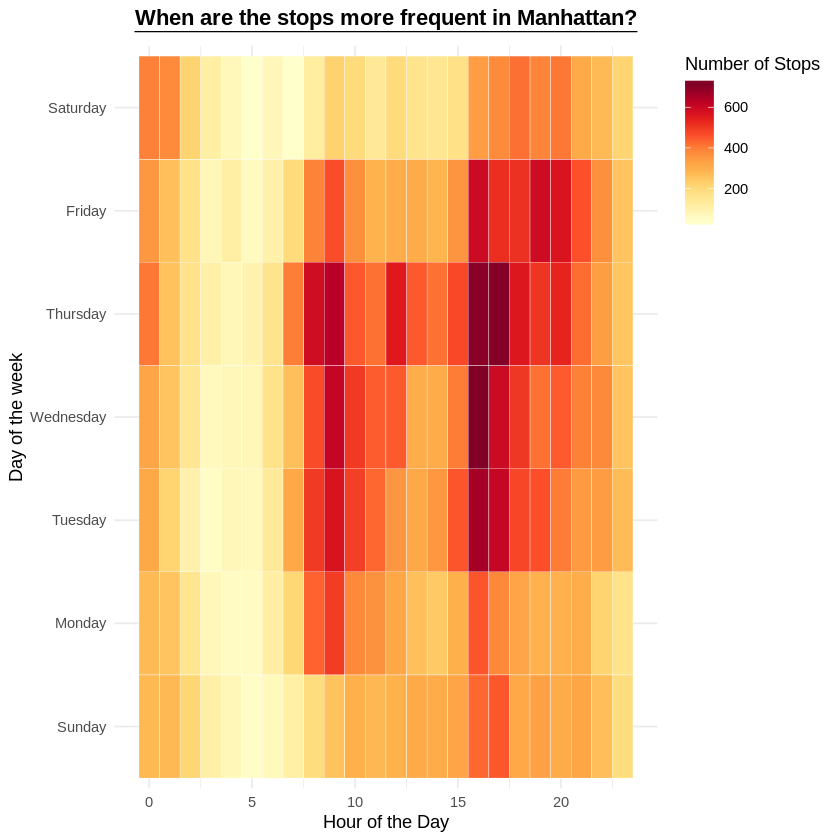

In [29]:
#Find the number of stops that happen per day per hour
d_hr <- df_m%>%
        group_by(Day, Hour)%>%
        summarise(count = n())

#Heat map
#Show the heatmap showing the frequency of stops by day of the week and hour of the day
d_hr$Day <- factor(d_hr$Day, levels = c('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'))

ggplot(d_hr, aes(Hour,Day,fill = count)) +  
geom_tile( color = "white") + 
scale_fill_gradientn(colors = co )+ 
labs(title = expression(bold(underline("When are the stops more frequent in Manhattan?"))), x = 'Hour of the Day', y = 'Day of the week', fill = 'Number of Stops') + 
theme_minimal() +
theme(plot.title = element_text(hjust=0.5),legend.justification = "top")

#ggsave("HeatMap.png") 

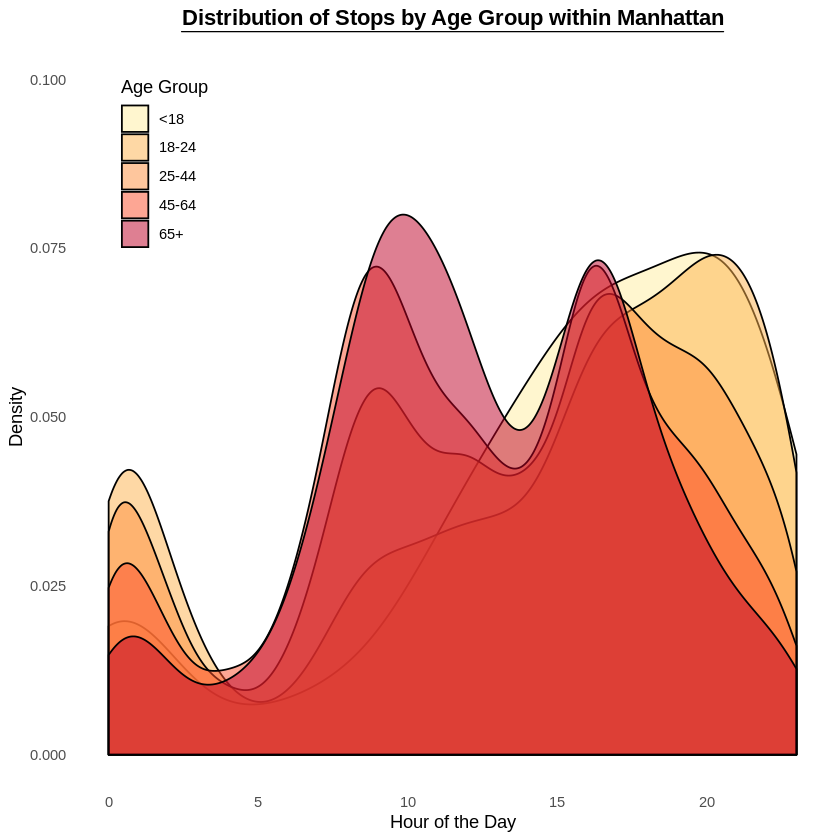

In [30]:
#Density plot
ggplot(df_m, aes(x = Hour, fill = Age_Group)) +
geom_density(alpha=0.50) +
scale_fill_manual(values = co1) +
labs(title = expression(bold(underline("Distribution of Stops by Age Group within Manhattan"))), x = "Hour of the Day", y = "Density",fill = "Age Group") +
theme_minimal()+
scale_y_continuous(limit = c(0,0.1))+
theme(plot.title = element_text(hjust=0.5), legend.position = c(0, 0.715), legend.justification = c(-0.35, 0),legend.direction='vertical',panel.grid.major = element_blank(), panel.grid.minor = element_blank())

#ggsave("Hr_Age.png")

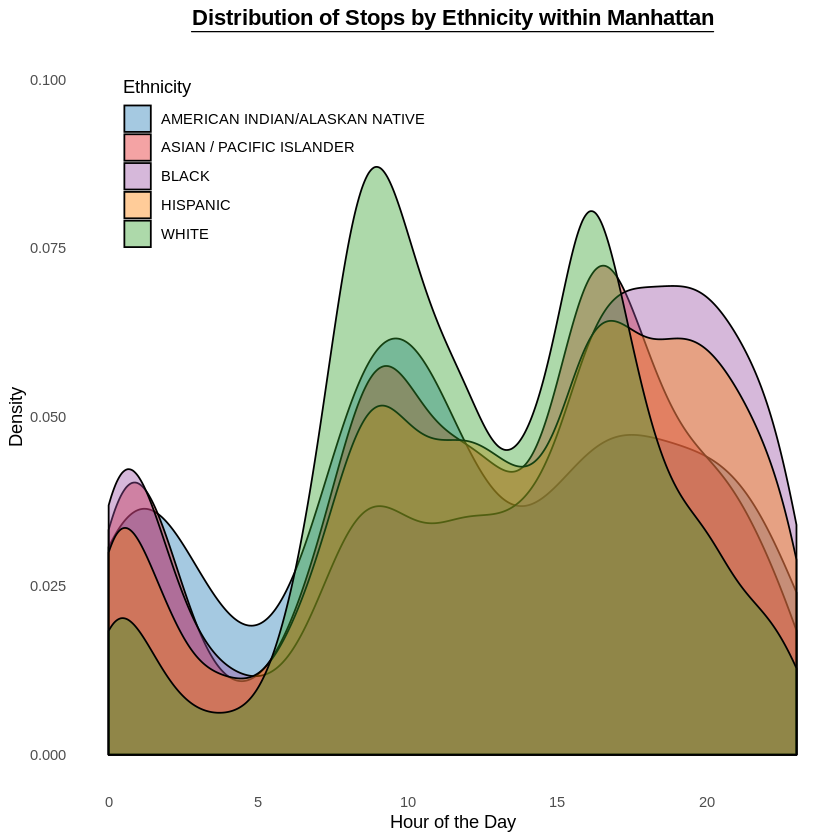

In [31]:
#Density plot
ggplot(df_m, aes(x = Hour, fill = Race)) +
geom_density(alpha = 0.4) +
scale_fill_manual(values = col_m) + 
labs(title = expression(bold(underline("Distribution of Stops by Ethnicity within Manhattan"))), x = "Hour of the Day", y = "Density", fill = "Ethnicity") +
theme_minimal()+
scale_y_continuous(limit = c(0,0.1))+
theme(plot.title = element_text(hjust=0.5), legend.position = c(0, 0.715), legend.justification = c(-0.13, 0),legend.direction='vertical',panel.grid.major = element_blank(), panel.grid.minor = element_blank())

#ggsave("Hr_Race.png") 